In [ ]:
import pandas as pd

In [ ]:
!pip install -q -U duckdb

     |████████████████████████████████| 14.4 MB 48.6 MB/s 


In [ ]:
!pip install -q -U fastcore

In [ ]:
from fastcore.utils import chunked

In [ ]:
import duckdb


In [ ]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

In [ ]:
df = pd.read_csv(url)

In [ ]:
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/16/22,12/17/22,12/18/22,12/19/22,12/20/22,12/21/22,12/22/22,12/23/22,12/24/22,12/25/22
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,206912,206943,207037,207084,207146,207190,207239,207262,207310,207399
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,333635,333635,333650,333653,333686,333708,333708,333731,333749,333749
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,271156,271168,271174,271179,271182,271186,271190,271193,271194,271198
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,47606,47606,47606,47606,47686,47686,47686,47686,47686,47686
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,104946,104946,104946,104946,104946,104973,104973,104973,104973,104973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,703228,703228,703228,703228,703228,703228,703228,703228,703228,703228
285,NaN,Winter Olympics 2022,39.904200,116.407400,0,0,0,0,0,0,...,535,535,535,535,535,535,535,535,535,535
286,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,11945,11945,11945,11945,11945,11945,11945,11945,11945,11945
287,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,333746,333746,333746,333746,333746,333746,333905,334021,334021,334021


In [ ]:
df = duckdb.query("""
select 
"Country/Region" as COUNTRY,"Province/State" as STATE,
* EXCLUDE("Country/Region","Province/State","Lat","Long")
 from df
 

"""
).to_df()

In [ ]:
df.head()

,COUNTRY,STATE,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,12/16/22,12/17/22,12/18/22,12/19/22,12/20/22,12/21/22,12/22/22,12/23/22,12/24/22,12/25/22
0,Afghanistan,NaN,0,0,0,0,0,0,0,0,...,206912,206943,207037,207084,207146,207190,207239,207262,207310,207399
1,Albania,NaN,0,0,0,0,0,0,0,0,...,333635,333635,333650,333653,333686,333708,333708,333731,333749,333749
2,Algeria,NaN,0,0,0,0,0,0,0,0,...,271156,271168,271174,271179,271182,271186,271190,271193,271194,271198
3,Andorra,NaN,0,0,0,0,0,0,0,0,...,47606,47606,47606,47606,47686,47686,47686,47686,47686,47686
4,Angola,NaN,0,0,0,0,0,0,0,0,...,104946,104946,104946,104946,104946,104973,104973,104973,104973,104973


In [ ]:
def bld_query(cols):
  
  query_list = []
  for col in cols:
      curr_dt = col
      query = f"""
  select COUNTRY,STATE,'{curr_dt}' as curr_date,"{curr_dt}" as NUM_CASES
  from COVID_CASES_RAW
  """
      query_list.append(query)
  return query_list









In [ ]:
cols = list(df.columns)


In [ ]:
!touch covid.db && rm covid.db.*

rm: cannot remove 'covid.db.*': No such file or directory


In [ ]:
!rm covid.db

In [ ]:
conn = duckdb.connect("covid.db")

In [ ]:
conn.execute("CREATE OR REPLACE TABLE COVID_CASES_RAW as SELECT * from df")

In [ ]:
queries = bld_query(cols[2:])

In [ ]:
len(queries)

1069

In [ ]:
first_query = queries[0]
first_query 
create_table_query = f"CREATE OR REPLACE TABLE COVID_CASES as {first_query}"

In [ ]:
conn.execute(create_table_query)

In [ ]:
for query_batch in chunked(queries[1:],chunk_sz=500):
  union_query = "union all\n".join(query_batch)
  query_denormalized = f"""
  INSERT INTO  COVID_CASES  {union_query}
  """
  conn.execute(query_denormalized)

In [ ]:
#union_query = "union all\n".join(bld_query(cols[2:]))
#query_denormalized = f""" 
#SET max_expression_depth to 1050 ;
#CREATE OR REPLACE TABLE COVID_CASES as {union_query};
#"""
#conn.execute(query_denormalized)

In [ ]:
query_dateformatted = """
CREATE OR REPLACE TABLE COVID_CASES_FORMATTED as
select * REPLACE (strptime(curr_date,'%m/%d/%y') as curr_date)
from COVID_CASES
"""
conn.execute(query_dateformatted)

In [ ]:
conn.execute("""
CREATE OR REPLACE TABLE COVID_CASES_DAILY AS 
with covid_base as (
select   * EXCLUDE(STATE) from 
 COVID_CASES_FORMATTED ),
covid_cases_grouped as (
 select * EXCLUDE(NUM_CASES),SUM(NUM_CASES)::BIGINT as NUM_CASES
 from covid_base 
 group by ALL )
 select *,(NUM_CASES - LAG(NUM_CASES,1,0) OVER(PARTITION BY COUNTRY ORDER BY CURR_DATE)) as DAILY_NUM_CASES
 from covid_cases_grouped
 
"""
).fetchdf()

,Count
0,214869


In [ ]:
query_7_day_avg = """
create or replace table COVID_CASES_7DAY_AVG as
select *,AVG(DAILY_NUM_CASES) 
 OVER(PARTITION BY COUNTRY ORDER BY CURR_DATE ASC RANGE BETWEEN INTERVAL 6 DAYS PRECEDING 
 AND CURRENT ROW
 ) as DAILY_CASES_7DAY_MVA,
 
 FROM COVID_CASES_DAILY
 
 """
conn.execute(query_7_day_avg).fetchdf()

,Count
0,214869


In [ ]:
conn.execute("select distinct COUNTRY from COVID_CASES_7DAY_AVG").fetchdf()

,COUNTRY
0,Algeria
1,Andorra
2,Antarctica
3,Argentina
4,Armenia
...,...
196,Lithuania
197,Micronesia
198,Niger
199,Vietnam


In [ ]:
%matplotlib inline

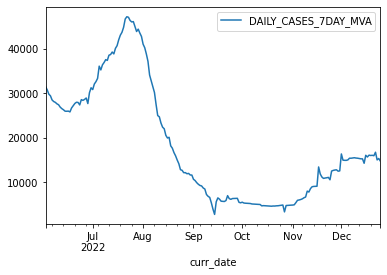

In [ ]:
import matplotlib.pyplot as plt
df = conn.execute("select * from COVID_CASES_7DAY_AVG where COUNTRY='Australia' and curr_date > '2022-06-01' ").fetchdf()
df.plot(kind='line',x='curr_date',y='DAILY_CASES_7DAY_MVA');

In [ ]:
df.tail()

,COUNTRY,curr_date,NUM_CASES,DAILY_NUM_CASES,DAILY_CASES_7DAY_MVA
1064,India,2022-12-21,44677739,185,152.714286
1065,India,2022-12-22,44677902,163,152.857143
1066,India,2022-12-23,44678103,201,157.714286
1067,India,2022-12-24,44678330,227,165.000000
1068,India,2022-12-25,44678517,187,172.428571


In [ ]:
#experimenting with range feature
#trying to code up xbar (from kdb) like functionality
query = """
with interval_range_raw as (
select x,LAG(x,1,NULL) OVER(ORDER BY x ASC) PREV_X from
(SELECT x  FROM range('2020-01-01'::DATE, '2022-12-31'::DATE, INTERVAL 10 DAY) tbl(x))
),
interval_range as (
select * from interval_range_raw where PREV_X is NOT NULL
),
grouped_10_day as (
select COUNTRY,PREV_X as CURR_DATE_10DAY,AVG(DAILY_NUM_CASES) as NUM_CASES_10DAY_AVG 
from 
COVID_CASES_7DAY_AVG,interval_range
where PREV_X <= curr_date and curr_date < x
GROUP BY ALL
)
select * from grouped_10_day
where CURR_DATE_10DAY >= current_date - 900
and COUNTRY='India'
ORDER BY CURR_DATE_10DAY


"""
conn.execute(query).fetchdf()

,COUNTRY,CURR_DATE_10DAY,NUM_CASES_10DAY_AVG
0,India,2020-07-09,31048.5
1,India,2020-07-19,45388.8
2,India,2020-07-29,55694.2
3,India,2020-08-08,61407.0
4,India,2020-08-18,68481.9
...,...,...,...
85,India,2022-11-06,732.1
86,India,2022-11-16,454.2
87,India,2022-11-26,256.4
88,India,2022-12-06,182.6


In [ ]:
from sqlalchemy import create_engine

In [ ]:
!touch covid_cases_7mva.sqlite && rm covid_cases_7mva.sqlite

In [ ]:
conn_sqlite = create_engine("sqlite:///covid_cases_7mva.sqlite")

In [ ]:
df.to_sql("COVID_CASES_7DAY_MVA",conn_sqlite,index=False)

In [ ]:
!ls

covid_cases_7mva.sqlite  covid.db  covid.db.wal  sample_data


In [ ]:
!touch covid2.db && rm covid2.db

In [ ]:
conn_2 = duckdb.connect(database='covid2.db')

In [ ]:
#sqlite_scanner.duckdb_extension
#
#INSTALL 'sqlite';
#LOAD 'sqlite';
#CALL sqlite_attach('covid_cases_7mva.sqlite');
conn_2.execute(f'''


select * from COVID_CASES_7DAY_MVA limit 10;
''').fetchdf()

CatalogException: ignored

In [ ]:
conn_2.execute(f'''
INSTALL 'httpfs';
LOAD 'httpfs';
create or replace table covid_raw as select * from read_csv_auto('{url}' );
select * from covid_raw limit 10;
''').fetchdf()